<a href="https://colab.research.google.com/github/kakiang/Hamoye-projects/blob/master/ML_classification_of_Stability_of_the_Grid_System_stage-C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stability of the Grid System
Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy source, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.

https://bit.ly/HDSC-StageThreeDataset

Dataset: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

It has 12 primary predictive features and two dependent variables.

### Predictive features:

1. __'tau1' to 'tau4'__: the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
2. __'p1' to 'p4'__: nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
3. __'g1' to 'g4'__: price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');

### Dependent variables:

1. __'stab'__: the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
2. __'stabf'__: a categorical (binary) label ('stable' or 'unstable').

Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), __'stab' should be dropped__ and 'stabf' will remain as the sole dependent variable (binary classification).

Split the data into an __80-20 train-test split__ with a __random state of "1"__. Use the __standard scaler__ to transform the train set (x_train, y_train) and the test set (x_test). Use __scikit learn__ to train a __random forest__ and __extra trees classifier__. And use __xgboost__ and __lightgbm__ to train an __extreme boosting model__ and a __light gradient boosting model__. Use __random_state = 1__ for training all models and evaluate on the test set. 

Also, to improve the Extra Trees Classifier, you will use the following parameters (number of estimators, minimum number of samples, minimum number of samples for leaf node and the number of features to consider when looking for the best split) for the hyperparameter grid needed to run a __Randomized Cross Validation Search (RandomizedSearchCV)__. 

```
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None] 
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}
```

In [309]:
import pandas as pd
import numpy as np

# Algorithms
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# training and testing set split
from sklearn.model_selection import train_test_split

# Hyperparameters search
from sklearn.model_selection import RandomizedSearchCV

# feature scaling
from sklearn.preprocessing import StandardScaler

# categorical features to numeric values ecoding
from sklearn.preprocessing import LabelEncoder

# evaluation metric
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt

# Multiple Cell Outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [310]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00471/Data_for_UCI_named.csv"
df = pd.read_csv(url)

In [311]:
df.sample(5)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
9993,5.754191,3.032743,5.084803,4.633624,5.199250,-1.717030,-1.713212,-1.769009,0.157284,0.975921,0.511555,0.696591,0.050212,unstable
7920,8.495331,7.606952,3.217939,2.428662,4.626098,-1.940888,-1.772451,-0.912759,0.218724,0.854847,0.209914,0.698561,0.012104,unstable
914,0.989826,2.097108,5.339491,5.312712,2.404153,-0.601866,-1.019907,-0.782380,0.127028,0.689045,0.111295,0.742447,-0.027474,stable
9331,0.949789,3.275222,9.235240,4.346157,3.871261,-1.201214,-1.752475,-0.917572,0.078717,0.744904,0.580935,0.899550,0.019914,unstable
7051,4.299831,4.782164,7.941514,5.465812,2.577699,-1.256360,-0.759252,-0.562087,0.337133,0.670412,0.569131,0.079580,0.021512,unstable


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [313]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403


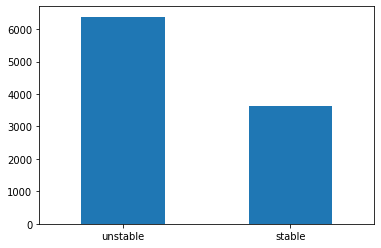

In [314]:
df.stabf.value_counts().plot(kind = 'bar', rot=0);

In [315]:
X = df.drop(columns = ['stab','stabf'])
y = df['stabf']

In [316]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# x_train = x_train.copy()
# x_test = x_test.copy()
y_train.shape, y_test.shape

((8000,), (2000,))

In [317]:
scaler = StandardScaler()

# scaling the training set
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_train = pd.DataFrame(scaled_x_train, columns = x_train.columns)

# scaling the testing set
scaled_x_test = scaler.transform(x_test)
scaled_x_test = pd.DataFrame(scaled_x_test, columns = x_test.columns)

In [318]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [319]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
# fit a Logistic Regression model
log_reg.fit(scaled_x_train, y_train)

y_pred = log_reg.predict(scaled_x_test)
accuracy = accuracy_score(y_test, y_pred)
print('\nFor reference, LogisticRegression Accuracy: {}'.format(round(accuracy, 4)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


For reference, LogisticRegression Accuracy: 0.804


In [320]:
def round_4(value):
  return round(value, 4)

def train_model(
    model,
    model_name=None,
    x_train=scaled_x_train,
    x_test=scaled_x_test,
    y_train=y_train,
    y_test=y_test,
):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label="unstable")
    recall = recall_score(y_test, y_pred, pos_label="unstable")
    f1 = f1_score(y_test, y_pred, pos_label="unstable")
    if not model_name:
        model_name = model.__class__.__name__
    return [model_name, round_4(accuracy), round_4(precision), round_4(recall), round_4(f1)]

In [321]:
RF = RandomForestClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
lgbm = LGBMClassifier(random_state=1)
extra_tree = ExtraTreesClassifier(random_state=1)
models = [RF, xgb, lgbm, extra_tree]

metrics = []
metrics_columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']
for model in models:
  metrics.append(train_model(model))

pd.DataFrame(metrics, columns=metrics_columns)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier,0.9290,0.9341,0.9573,0.9456
1,XGBClassifier,0.9195,0.9190,0.9596,0.9389
2,LGBMClassifier,0.9375,0.9415,0.9627,0.9520
3,ExtraTreesClassifier,0.9280,0.9218,0.9705,0.9455


In [322]:
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None] 
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [323]:
# Best hyperparameters from the randomized search CV
extra_tree_rscv.best_params_

{'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [324]:
best_extra_tree = ExtraTreesClassifier(random_state=1,**extra_tree_rand_search.best_params_)
pd.DataFrame([train_model(best_extra_tree,model_name='RandomizedSearchCV')], columns=metrics_columns)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomizedSearchCV,0.927,0.93,0.9589,0.9442


In [325]:
pd.DataFrame(
    [train_model(extra_tree_rscv.best_estimator_, model_name="RandomizedSearchCV")],
    columns=metrics_columns)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomizedSearchCV,0.927,0.93,0.9589,0.9442


In [326]:
feature_importances = best_extra_tree.feature_importances_
feature_importances

array([0.13723975, 0.1405075 , 0.13468029, 0.13541676, 0.00368342,
       0.00533686, 0.00542927, 0.00496249, 0.10256244, 0.10757765,
       0.11306268, 0.10954089])

In [327]:
arr = sorted(zip([round(i,3) for i in feature_importances[sorted_idx]] , scaled_x_train.columns[sorted_idx]),reverse=True)
arr[0], arr[-1]

((0.141, 'tau2'), (0.004, 'p1'))

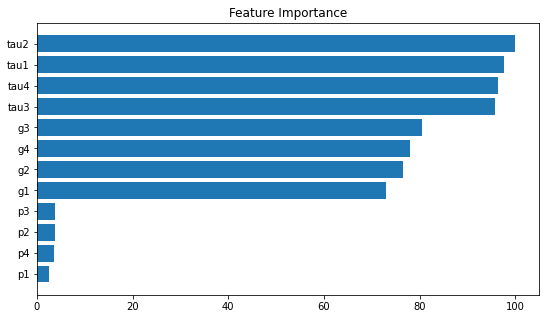

In [328]:
# plt.barh(X.columns, 100.0 * (feature_importances / feature_importances.max()))
plt.figure(figsize=(9, 5))
plt.title("Feature Importance")
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0])
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.show();

In [329]:
tp = 355
tn = 120
fp = 1480
fn = 45
precision = tp / (tp + fp)
recall= tp / (tp + fn)
f1 =  (2 * precision * recall) / (precision + recall)

round(f1, 4)

0.3177

In [330]:
def comp_recall():
  return tp*100 / (tp + fn)

def comp_fpr():
  return fp*100 / (fp + tn)

def comp_precision():
  return tp*100 / (tp + fp)

def comp_cost():
  return 5 * fp + fn
# 1
tn = 98
fp = 2
fn = 18
tp = 82
print('1-', 'Recall:',comp_recall(), 'FPR:', comp_fpr(), 'Cost:', comp_cost())

tn = 91
fp = 9
fn = 22
tp = 78
print('2-', 'Recall:',comp_recall(), 'FPR:', comp_fpr(), 'Cost:', comp_cost())

tn = 96
fp = 4
fn = 10
tp = 90
print('3-', 'Recall:',comp_recall(), 'FPR:', comp_fpr(), 'Cost:', comp_cost())

tn = 99
fp = 1
fn = 21
tp = 79
print('4-', 'Recall:',comp_recall(), 'FPR:', comp_fpr(), 'Cost:', comp_cost())

1- Recall: 82.0 FPR: 2.0 Cost: 28
2- Recall: 78.0 FPR: 9.0 Cost: 67
3- Recall: 90.0 FPR: 4.0 Cost: 30
4- Recall: 79.0 FPR: 1.0 Cost: 26
